In [56]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pprint
from math import sqrt
from sklearn.metrics import mean_squared_error
%matplotlib inline

In [12]:
# load data
df = pd.read_json('test.json')

In [13]:
# aggregate data into 15min interval
df.set_index('login_time', inplace=True)
df['count']=1
df_agg = df.resample('15T').sum()
df_agg.head()

,count
login_time,
2010-01-01 00:00:00,3
2010-01-01 00:15:00,3
2010-01-01 00:30:00,7
2010-01-01 00:45:00,7
2010-01-01 01:00:00,5


Text(0, 0.5, 'number of login')

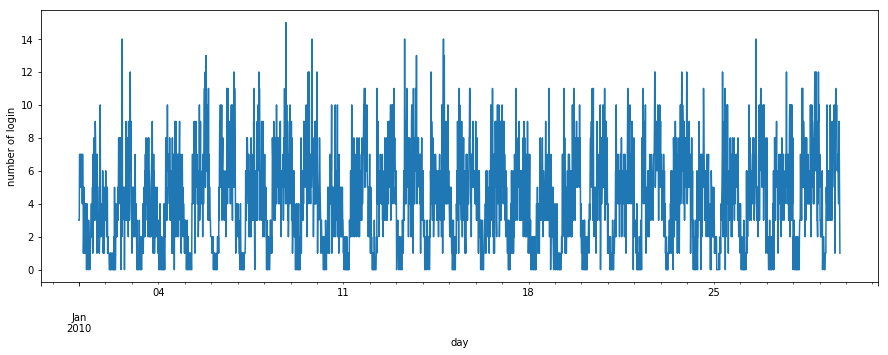

In [17]:
# plot all data
df_agg['count'].plot(figsize=(15,5))
plt.xlabel('day')
plt.ylabel('number of login')

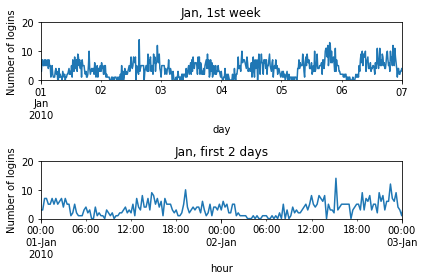

In [20]:
# Enlarge and focus on the first week of Jan
plt.subplot(2, 1, 1)
df_agg['count'].plot()
plt.axis(['2010-01-01', '2010-01-7', 0, 20])
plt.xlabel('day')
plt.ylabel('Number of logins')
plt.title('Jan, 1st week')

# Enlarge and focus on the first 4 days of Jan
plt.subplot(2, 1, 2)
df_agg['count'].plot()
plt.axis(['2010-01-01', '2010-01-03', 0, 20])
plt.xlabel('hour')
plt.ylabel('Number of logins')
plt.title('Jan, first 2 days')

plt.tight_layout()

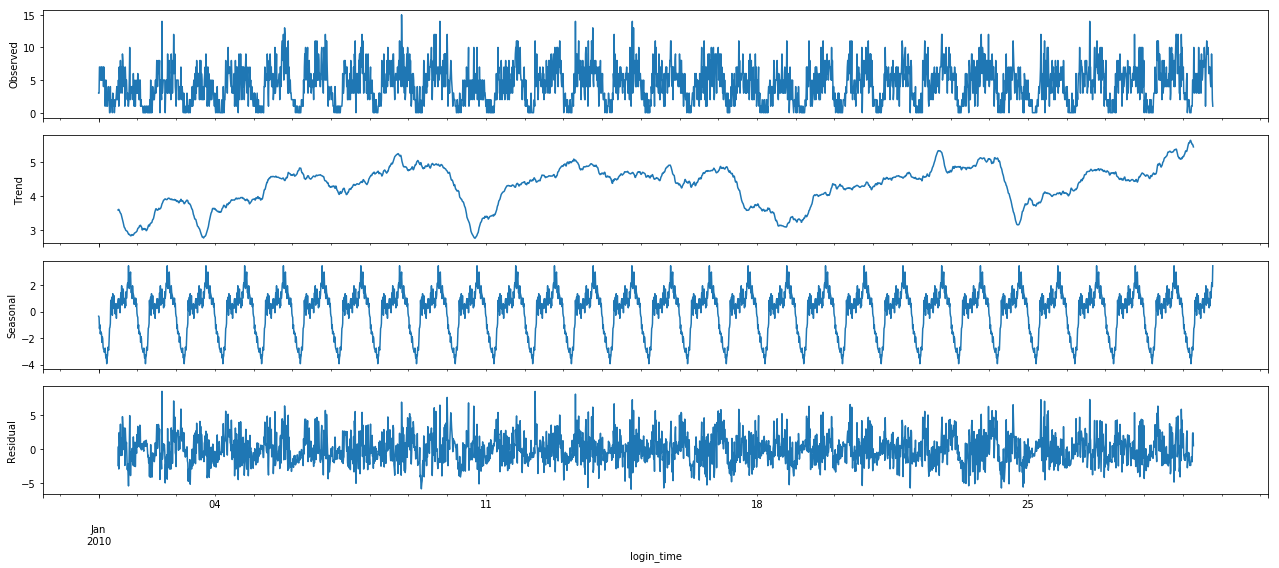

In [22]:
# decompose the data for trend, seasonality, residual
from statsmodels.tsa.seasonal import seasonal_decompose
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = seasonal_decompose(df_agg, model='additive', freq=96)
decomposition.plot()
plt.show()

Text(0.5, 1.0, 'ACF')

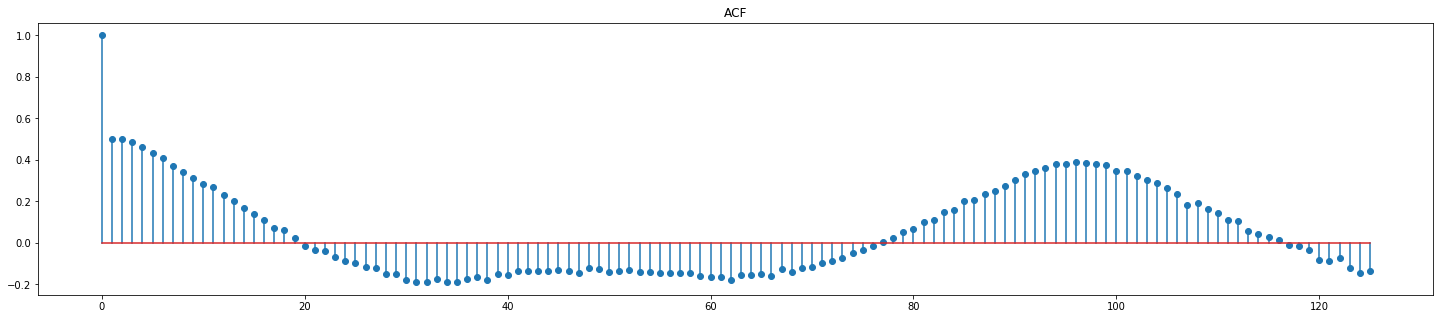

In [28]:
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(df_agg, nlags=125)
plt.figure(figsize=(25,5))
plt.stem(lag_acf)
plt.title('ACF')

Text(0.5, 1.0, 'PACF')

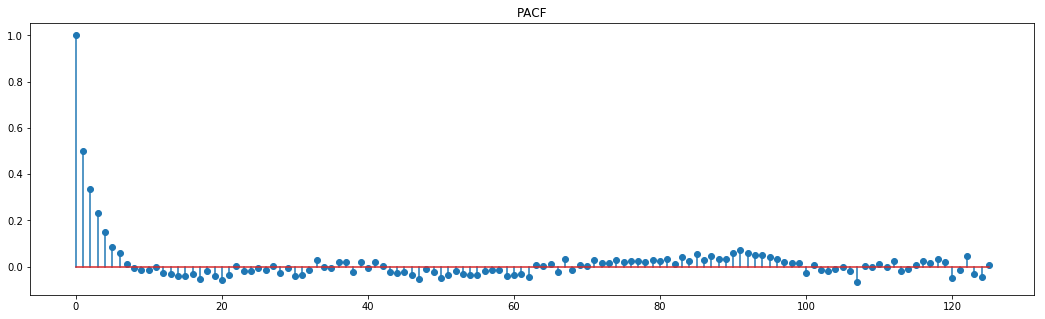

In [27]:
lag_pacf = pacf(df_agg, nlags=125)
plt.figure(figsize=(18,5))
plt.stem(lag_pacf)
plt.title('PACF')

# SARAIMAX() approach

In [29]:
p = range(0, 2)
d = range(0, 2)
q = range(0, 2)

In [46]:
import itertools
pdq_only = list(itertools.product(p, d, q))
pdq_only

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [51]:
seasonal_pdq = []
for i in pdq_only:
    seasonal_pdq.append((i[0], i[1], i[2], 96))
pprint.pprint(seasonal_pdq)

[(0, 0, 0, 96),
 (0, 0, 1, 96),
 (0, 1, 0, 96),
 (0, 1, 1, 96),
 (1, 0, 0, 96),
 (1, 0, 1, 96),
 (1, 1, 0, 96),
 (1, 1, 1, 96)]


In [41]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [45]:
train = df_agg.loc['2010-01-01':'2010-01-06']

for combo in pdq_only:
    for combo_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=combo, seasonal_order=combo_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            print('pdq{} x seasonal_pdq{}, AIC={}'.format(combo, combo_seasonal, model_fit.aic))
        except:
            continue

/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


pdq(0, 0, 0) x seasonal_pdq(0, 0, 0, 96), AIC=3437.1665494269046
pdq(0, 0, 0) x seasonal_pdq(0, 1, 0, 96), AIC=2435.2171800103606
pdq(0, 0, 0) x seasonal_pdq(1, 0, 0, 96), AIC=2411.9854264220958
pdq(0, 0, 0) x seasonal_pdq(1, 0, 1, 96), AIC=2345.4832764269304
pdq(0, 0, 0) x seasonal_pdq(1, 1, 0, 96), AIC=1850.840852147522
pdq(0, 0, 0) x seasonal_pdq(1, 1, 1, 96), AIC=1847.6734722817646
pdq(0, 0, 1) x seasonal_pdq(0, 0, 0, 96), AIC=3126.2854574881103
pdq(0, 0, 1) x seasonal_pdq(0, 0, 1, 96), AIC=2514.8789984981104
pdq(0, 0, 1) x seasonal_pdq(0, 1, 0, 96), AIC=2414.001658301104
pdq(0, 0, 1) x seasonal_pdq(0, 1, 1, 96), AIC=1813.7703954881058
pdq(0, 0, 1) x seasonal_pdq(1, 0, 0, 96), AIC=2378.3354351982553
pdq(0, 0, 1) x seasonal_pdq(1, 0, 1, 96), AIC=2308.591627396073
pdq(0, 0, 1) x seasonal_pdq(1, 1, 0, 96), AIC=1836.1515933465953
pdq(0, 0, 1) x seasonal_pdq(1, 1, 1, 96), AIC=1827.226680371617
pdq(0, 1, 0) x seasonal_pdq(0, 0, 0, 96), AIC=2787.095630473058
pdq(0, 1, 0) x seasonal_pdq(0,

In [52]:
# train and fit model by the best pdq and seasonal pdq combinations with the lowest AIC
model_5=SARIMAX(train, order=(1,0,1), seasonal_order=(0,1,1,96),enforce_stationarity=False, enforce_invertibility=False)
model_fit_5 = model_5.fit()

In [54]:
# predict login numbers in the following hour
hour_5 = model_fit_5.predict(start='2010-01-06 00:00:00',end='2010-01-06 01:00:00')
observe_5 = df_agg.loc['2010-01-06 00:00:00':'2010-01-06 01:00:00']
hour_5_pd = pd.DataFrame(hour_5, index = observe_5.index, columns=['Prediction'])

The prediction accuracy from the model with previous 5 days info is 0.9605411129782355.


Text(0.5, 1.0, '1st hour of Jan 6 ')

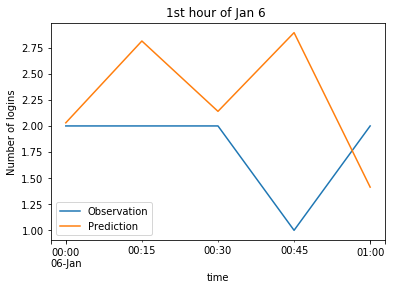

In [64]:
# accuracy and plot comparasion
accuracy_5 = sqrt(mean_squared_error(observe_5, hour_5_pd))
print('The prediction accuracy from the model with previous 5 days info is {}.'.format(accuracy_5))

pd.concat([observe_5, hour_5_pd], axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('time')
plt.ylabel('Number of logins')
plt.title('1st hour of Jan 6 ')

In [58]:
# predict login numbers in the following week
hour_5_week = model_fit_5.predict(start='2010-01-06 00:00:00',end='2010-01-13 00:00:00')
observe_5_week = df_agg.loc['2010-01-06 00:00:00':'2010-01-13 00:00:00']
hour_5_week_pd = pd.DataFrame(hour_5_week, index = observe_5_week.index, columns=['Prediction'])

The prediction accuracy from the model with previous 5 days info is 2.4415852297085445.


Text(0.5, 1.0, 'Jan 6 - Jan 13')

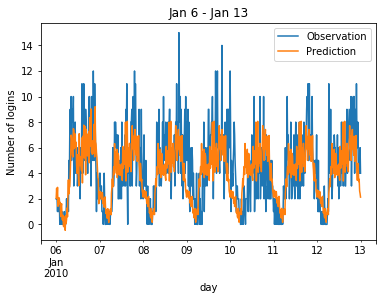

In [63]:
# accuracy and plot comparasion
accuracy_5_week = sqrt(mean_squared_error(observe_5_week, hour_5_week_pd))
print('The prediction accuracy from the model with previous 5 days info is {}.'.format(accuracy_5_week))

pd.concat([observe_5_week, hour_5_week_pd], axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('day')
plt.ylabel('Number of logins')
plt.title('Jan 6 - Jan 13')

In [65]:
train = df_agg.loc['2010-01-01':'2010-01-05']

for combo in pdq_only:
    for combo_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=combo, seasonal_order=combo_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            print('pdq{} x seasonal_pdq{}, AIC={}'.format(combo, combo_seasonal, model_fit.aic))
        except:
            continue

/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


pdq(0, 0, 0) x seasonal_pdq(0, 0, 0, 96), AIC=2832.6351437947333
pdq(0, 0, 0) x seasonal_pdq(0, 0, 1, 96), AIC=2120.985604185274
pdq(0, 0, 0) x seasonal_pdq(0, 1, 0, 96), AIC=1958.1918354815775


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 0, 0) x seasonal_pdq(0, 1, 1, 96), AIC=9815.744101345343
pdq(0, 0, 0) x seasonal_pdq(1, 0, 0, 96), AIC=1942.6323073706362
pdq(0, 0, 0) x seasonal_pdq(1, 0, 1, 96), AIC=1899.5779202106517
pdq(0, 0, 0) x seasonal_pdq(1, 1, 0, 96), AIC=1407.7780858347983


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 0, 0) x seasonal_pdq(1, 1, 1, 96), AIC=12247.425110712524
pdq(0, 0, 1) x seasonal_pdq(0, 0, 0, 96), AIC=2587.2951029850005
pdq(0, 0, 1) x seasonal_pdq(0, 0, 1, 96), AIC=2001.5472035897349
pdq(0, 0, 1) x seasonal_pdq(0, 1, 0, 96), AIC=1936.1503239391818


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 0, 1) x seasonal_pdq(0, 1, 1, 96), AIC=10319.626616825888
pdq(0, 0, 1) x seasonal_pdq(1, 0, 0, 96), AIC=1909.8461883297205
pdq(0, 0, 1) x seasonal_pdq(1, 0, 1, 96), AIC=1864.01392049053
pdq(0, 0, 1) x seasonal_pdq(1, 1, 0, 96), AIC=1393.8929685203307


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 0, 1) x seasonal_pdq(1, 1, 1, 96), AIC=10530.343086942597
pdq(0, 1, 0) x seasonal_pdq(0, 0, 0, 96), AIC=2329.300324582854
pdq(0, 1, 0) x seasonal_pdq(0, 0, 1, 96), AIC=1877.6792364793414
pdq(0, 1, 0) x seasonal_pdq(0, 1, 0, 96), AIC=2102.805314936726


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 1, 0) x seasonal_pdq(0, 1, 1, 96), AIC=10234.10235076026
pdq(0, 1, 0) x seasonal_pdq(1, 0, 0, 96), AIC=1882.7159735050463
pdq(0, 1, 0) x seasonal_pdq(1, 0, 1, 96), AIC=1879.6021255702676
pdq(0, 1, 0) x seasonal_pdq(1, 1, 0, 96), AIC=1510.2198845473756


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 1, 0) x seasonal_pdq(1, 1, 1, 96), AIC=7285.2007675393115
pdq(0, 1, 1) x seasonal_pdq(0, 0, 0, 96), AIC=2082.408188161793
pdq(0, 1, 1) x seasonal_pdq(0, 0, 1, 96), AIC=1679.4946683230091
pdq(0, 1, 1) x seasonal_pdq(0, 1, 0, 96), AIC=1882.8285608574454


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 1, 1) x seasonal_pdq(0, 1, 1, 96), AIC=6888.823257217259
pdq(0, 1, 1) x seasonal_pdq(1, 0, 0, 96), AIC=1687.552432947196
pdq(0, 1, 1) x seasonal_pdq(1, 0, 1, 96), AIC=1681.2485563401028
pdq(0, 1, 1) x seasonal_pdq(1, 1, 0, 96), AIC=1354.5612593780272


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(0, 1, 1) x seasonal_pdq(1, 1, 1, 96), AIC=6746.1957953552155
pdq(1, 0, 0) x seasonal_pdq(0, 0, 0, 96), AIC=2290.875620955552
pdq(1, 0, 0) x seasonal_pdq(0, 0, 1, 96), AIC=1843.9930150833954
pdq(1, 0, 0) x seasonal_pdq(0, 1, 0, 96), AIC=1933.236002443844


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 0, 0) x seasonal_pdq(0, 1, 1, 96), AIC=8108.647701671846
pdq(1, 0, 0) x seasonal_pdq(1, 0, 0, 96), AIC=1841.8292368700554
pdq(1, 0, 0) x seasonal_pdq(1, 0, 1, 96), AIC=1842.460816043561
pdq(1, 0, 0) x seasonal_pdq(1, 1, 0, 96), AIC=1383.0557225169332


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 0, 0) x seasonal_pdq(1, 1, 1, 96), AIC=8312.770908033706
pdq(1, 0, 1) x seasonal_pdq(0, 0, 0, 96), AIC=2087.8318460898395
pdq(1, 0, 1) x seasonal_pdq(0, 0, 1, 96), AIC=1683.9376616893967
pdq(1, 0, 1) x seasonal_pdq(0, 1, 0, 96), AIC=1880.6582171686423


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 0, 1) x seasonal_pdq(0, 1, 1, 96), AIC=9104.813467605478
pdq(1, 0, 1) x seasonal_pdq(1, 0, 0, 96), AIC=1687.6244657201669
pdq(1, 0, 1) x seasonal_pdq(1, 0, 1, 96), AIC=1685.779901567759
pdq(1, 0, 1) x seasonal_pdq(1, 1, 0, 96), AIC=1347.4309185433804


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 0, 1) x seasonal_pdq(1, 1, 1, 96), AIC=9318.934602320569
pdq(1, 1, 0) x seasonal_pdq(0, 0, 0, 96), AIC=2176.327784391122
pdq(1, 1, 0) x seasonal_pdq(0, 0, 1, 96), AIC=1755.9709826155881
pdq(1, 1, 0) x seasonal_pdq(0, 1, 0, 96), AIC=1989.32111732787


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 1, 0) x seasonal_pdq(0, 1, 1, 96), AIC=8856.458987869744
pdq(1, 1, 0) x seasonal_pdq(1, 0, 0, 96), AIC=1756.3647067719721
pdq(1, 1, 0) x seasonal_pdq(1, 0, 1, 96), AIC=1757.970130783242
pdq(1, 1, 0) x seasonal_pdq(1, 1, 0, 96), AIC=1426.763636841283


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 1, 0) x seasonal_pdq(1, 1, 1, 96), AIC=8748.28711664546
pdq(1, 1, 1) x seasonal_pdq(0, 0, 0, 96), AIC=2079.285676786571
pdq(1, 1, 1) x seasonal_pdq(0, 0, 1, 96), AIC=1677.315790324512
pdq(1, 1, 1) x seasonal_pdq(0, 1, 0, 96), AIC=1883.305808234948


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 1, 1) x seasonal_pdq(0, 1, 1, 96), AIC=8897.34164088135
pdq(1, 1, 1) x seasonal_pdq(1, 0, 0, 96), AIC=1681.6087782562108
pdq(1, 1, 1) x seasonal_pdq(1, 0, 1, 96), AIC=1679.1449467789598
pdq(1, 1, 1) x seasonal_pdq(1, 1, 0, 96), AIC=1350.5227816537158


/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


pdq(1, 1, 1) x seasonal_pdq(1, 1, 1, 96), AIC=8789.436710625283


In [66]:
# train and fit model by the best pdq and seasonal pdq combinations with the lowest AIC
model_4=SARIMAX(train, order=(1,0,1), seasonal_order=(1,1,0,96),enforce_stationarity=False, enforce_invertibility=False)
model_fit_4 = model_4.fit()

In [67]:
# predict login numbers in the following hour
hour_4 = model_fit_4.predict(start='2010-01-05 00:00:00',end='2010-01-05 01:00:00')
observe_4 = df_agg.loc['2010-01-05 00:00:00':'2010-01-05 01:00:00']
hour_4_pd = pd.DataFrame(hour_4, index = observe_4.index, columns=['Prediction'])

The prediction accuracy from the model with previous 4 days info is 1.0771469408336507.


Text(0.5, 1.0, '1st hour of Jan 5 ')

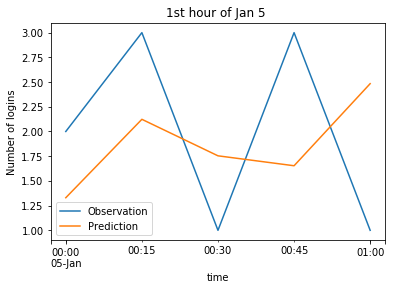

In [68]:
# accuracy and plot comparasion
accuracy_4 = sqrt(mean_squared_error(observe_4, hour_4_pd))
print('The prediction accuracy from the model with previous 4 days info is {}.'.format(accuracy_4))

pd.concat([observe_4, hour_4_pd], axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('time')
plt.ylabel('Number of logins')
plt.title('1st hour of Jan 5 ')

In [69]:
# predict login numbers in the following week
hour_4_week = model_fit_4.predict(start='2010-01-05 00:00:00',end='2010-01-12 00:00:00')
observe_4_week = df_agg.loc['2010-01-05 00:00:00':'2010-01-12 00:00:00']
hour_4_week_pd = pd.DataFrame(hour_4_week, index = observe_4_week.index, columns=['Prediction'])

The prediction accuracy from the model with previous 4 days info is 2.8549021298041635.


Text(0.5, 1.0, 'Jan 5 - Jan 12')

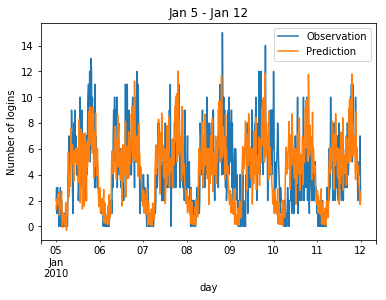

In [70]:
# accuracy and plot comparasion
accuracy_4_week = sqrt(mean_squared_error(observe_4_week, hour_4_week_pd))
print('The prediction accuracy from the model with previous 4 days info is {}.'.format(accuracy_4_week))

pd.concat([observe_4_week, hour_4_week_pd], axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('day')
plt.ylabel('Number of logins')
plt.title('Jan 5 - Jan 12')

In [71]:
train = df_agg.loc['2010-01-01':'2010-01-02']

for combo in pdq_only:
    for combo_seasonal in seasonal_pdq:
        try:
            model = SARIMAX(train, order=combo, seasonal_order=combo_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            model_fit = model.fit()
            print('pdq{} x seasonal_pdq{}, AIC={}'.format(combo, combo_seasonal, model_fit.aic))
        except:
            continue

/Users/GaryKao/Desktop/Springboard/env/lib/python3.6/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


pdq(0, 0, 0) x seasonal_pdq(0, 0, 0, 96), AIC=1112.5340574970965
pdq(0, 0, 0) x seasonal_pdq(0, 1, 0, 96), AIC=498.3930718384855
pdq(0, 0, 0) x seasonal_pdq(1, 0, 0, 96), AIC=497.50311911126823
pdq(0, 0, 1) x seasonal_pdq(0, 0, 0, 96), AIC=1025.5416863840164
pdq(0, 0, 1) x seasonal_pdq(0, 1, 0, 96), AIC=489.4503130838346
pdq(0, 0, 1) x seasonal_pdq(1, 0, 0, 96), AIC=490.8430552497061
pdq(0, 1, 0) x seasonal_pdq(0, 0, 0, 96), AIC=936.7898788204008
pdq(0, 1, 0) x seasonal_pdq(0, 1, 0, 96), AIC=525.4918132347769
pdq(0, 1, 0) x seasonal_pdq(1, 0, 0, 96), AIC=489.5080363447927
pdq(0, 1, 1) x seasonal_pdq(0, 0, 0, 96), AIC=828.1937554627004
pdq(0, 1, 1) x seasonal_pdq(0, 1, 0, 96), AIC=468.1750781934015
pdq(0, 1, 1) x seasonal_pdq(1, 0, 0, 96), AIC=435.38288728171545
pdq(1, 0, 0) x seasonal_pdq(0, 0, 0, 96), AIC=922.226187558177
pdq(1, 0, 0) x seasonal_pdq(0, 1, 0, 96), AIC=491.65050697079545
pdq(1, 0, 0) x seasonal_pdq(1, 0, 0, 96), AIC=476.76487851121055
pdq(1, 0, 1) x seasonal_pdq(0, 0, 0

In [72]:
# train and fit model by the best pdq and seasonal pdq combinations with the lowest AIC
model_2=SARIMAX(train, order=(1,1,1), seasonal_order=(1,0,0,96),enforce_stationarity=False, enforce_invertibility=False)
model_fit_2 = model_2.fit()

In [73]:
# predict login numbers in the following hour
hour_2 = model_fit_2.predict(start='2010-01-02 00:00:00',end='2010-01-02 01:00:00')
observe_2 = df_agg.loc['2010-01-02 00:00:00':'2010-01-02 01:00:00']
hour_2_pd = pd.DataFrame(hour_2, index = observe_2.index, columns=['Prediction'])

The prediction accuracy from the model with previous 2 days info is 1.7771865158028053.


Text(0.5, 1.0, '1st hour of Jan 2 ')

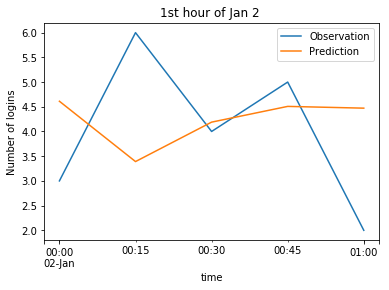

In [87]:
# accuracy and plot comparasion
accuracy_2 = sqrt(mean_squared_error(observe_2, hour_2_pd))
print('The prediction accuracy from the model with previous 2 days info is {}.'.format(accuracy_2))

pd.concat([observe_2, hour_2_pd], axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('time')
plt.ylabel('Number of logins')
plt.title('1st hour of Jan 2 ')

In [75]:
# predict login numbers in the following week
hour_2_week = model_fit_2.predict(start='2010-01-02 00:00:00',end='2010-01-09 00:00:00')
observe_2_week = df_agg.loc['2010-01-02 00:00:00':'2010-01-09 00:00:00']
hour_2_week_pd = pd.DataFrame(hour_2_week, index = observe_2_week.index, columns=['Prediction'])

The prediction accuracy from the model with previous 2 days info is 3.148706296205356.


Text(0.5, 1.0, 'Jan 2 - Jan 9')

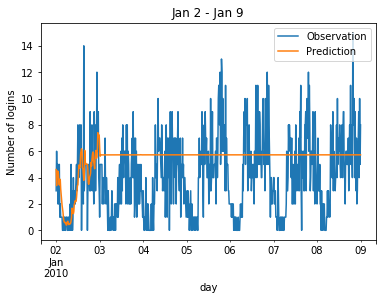

In [76]:
# accuracy and plot comparasion
accuracy_2_week = sqrt(mean_squared_error(observe_2_week, hour_2_week_pd))
print('The prediction accuracy from the model with previous 2 days info is {}.'.format(accuracy_2_week))

pd.concat([observe_2_week, hour_2_week_pd], axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('day')
plt.ylabel('Number of logins')
plt.title('Jan 2 - Jan 9')

# Auto.arima() approach

In [78]:
from pyramid.arima import auto_arima

train = df_agg.loc['2010-01-01':'2010-01-06']

auto_5 = auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=96,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 96); AIC=2247.647, BIC=2268.505, Fit time=149.166 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 96); AIC=2647.114, BIC=2655.457, Fit time=6.831 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 96); AIC=2407.669, BIC=2424.356, Fit time=78.195 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 96); AIC=2246.710, BIC=2263.397, Fit time=100.694 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 96); AIC=2248.710, BIC=2269.569, Fit time=150.685 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 96); AIC=2380.143, BIC=2392.658, Fit time=24.524 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 96); AIC=2476.766, BIC=2489.281, Fit time=185.679 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=

In [82]:
# predict login numbers in the following hour

valid = df_agg.loc['2010-01-06 00:00:00':'2010-01-06 01:00:00']

auto_5.fit(train)
auto_5_prediction = auto_5.predict(n_periods=len(valid))
auto_5_prediction_pd = pd.DataFrame(auto_5_prediction, index = valid.index, columns=['Prediction'])

The prediction accuracy from the model with previous 5 days info is 0.7582012271043547.


Text(0.5, 1.0, '1st hour of Jan 6 ')

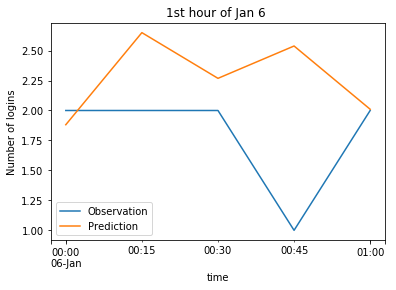

In [83]:
# accuracy and plot comparasion
auto_5_accuracy = sqrt(mean_squared_error(valid, auto_5_prediction_pd))
print('The prediction accuracy from the model with previous 5 days info is {}.'.format(auto_5_accuracy))

pd.concat([valid, auto_5_prediction_pd],axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('time')
plt.ylabel('Number of logins')
plt.title('1st hour of Jan 6 ')

In [84]:
# predict login numbers in the following week

valid = df_agg.loc['2010-01-06 00:00:00':'2010-01-13 00:00:00']

auto_5.fit(train)
auto_5_prediction_week = auto_5.predict(n_periods=len(valid))
auto_5_prediction_week_pd = pd.DataFrame(auto_5_prediction_week, index = valid.index, columns=['Prediction'])

The prediction accuracy from the model with previous 5 days info is 5.158588997229098.


Text(0.5, 1.0, 'Jan 6 - Jan 13 ')

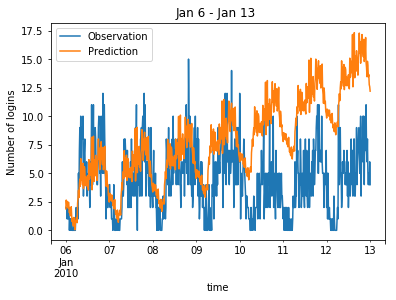

In [85]:
# accuracy and plot comparasion
auto_5_accuracy_week = sqrt(mean_squared_error(valid, auto_5_prediction_week_pd))
print('The prediction accuracy from the model with previous 5 days info is {}.'.format(auto_5_accuracy_week))

pd.concat([valid, auto_5_prediction_week_pd],axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('time')
plt.ylabel('Number of logins')
plt.title('Jan 6 - Jan 13 ')

In [86]:
from pyramid.arima import auto_arima

train = df_agg.loc['2010-01-01':'2010-01-02']

auto_2 = auto_arima(train, start_p=1, start_q=1,max_p=3, max_q=3, m=96,start_P=0, seasonal=True,d=1, D=1, trace=True,error_action='ignore',suppress_warnings=True,stepwise=True)

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 96); AIC=532.643, BIC=537.751, Fit time=1.898 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 0, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(1, 1, 1, 96); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 0, 96); AIC=504.569, BIC=512.231, Fit time=4.914 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 96); AIC=482.131, BIC=492.347, Fit time=11.109 seconds
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 0, 96); AIC=485.788, BIC=501.111, Fit time=25.490 second

In [88]:
# predict login numbers in the following hour

valid = df_agg.loc['2010-01-02 00:00:00':'2010-01-02 01:00:00']

auto_2.fit(train)
auto_2_prediction = auto_2.predict(n_periods=len(valid))
auto_2_prediction_pd = pd.DataFrame(auto_2_prediction, index = valid.index, columns=['Prediction'])

The prediction accuracy from the model with previous 2 days info is 2.9591532332955865.


Text(0.5, 1.0, '1st hour of Jan 2 ')

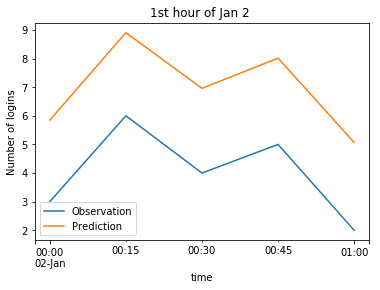

In [89]:
# accuracy and plot comparasion
auto_2_accuracy = sqrt(mean_squared_error(valid, auto_2_prediction_pd))
print('The prediction accuracy from the model with previous 2 days info is {}.'.format(auto_2_accuracy))

pd.concat([valid, auto_2_prediction_pd],axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('time')
plt.ylabel('Number of logins')
plt.title('1st hour of Jan 2 ')

In [90]:
# predict login numbers in the following week

valid = df_agg.loc['2010-01-02 00:00:00':'2010-01-09 00:00:00']

auto_2.fit(train)
auto_2_prediction_week = auto_2.predict(n_periods=len(valid))
auto_2_prediction_week_pd = pd.DataFrame(auto_2_prediction_week, index = valid.index, columns=['Prediction'])

The prediction accuracy from the model with previous 2 days info is 80.02597172930714.


Text(0.5, 1.0, 'Jan 2 - Jan 9 ')

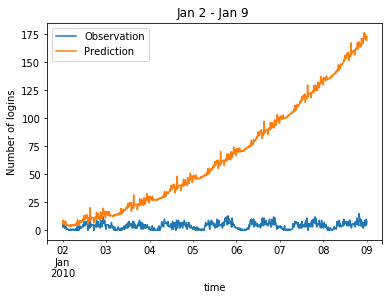

In [91]:
# accuracy and plot comparasion
auto_2_accuracy_week = sqrt(mean_squared_error(valid, auto_2_prediction_week_pd))
print('The prediction accuracy from the model with previous 2 days info is {}.'.format(auto_2_accuracy_week))

pd.concat([valid, auto_2_prediction_week_pd],axis=1).plot()
plt.legend(labels=['Observation','Prediction'])
plt.xlabel('time')
plt.ylabel('Number of logins')
plt.title('Jan 2 - Jan 9 ')